# Dataset
In this homework, we will use the California Housing Prices from Kaggle.

Here's a wget-able link:

```wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv```

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').


In [8]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [9]:
!wget $data

--2023-09-25 10:58:16--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M   663KB/s    in 2.1s    

2023-09-25 10:58:18 (663 KB/s) - ‘housing.csv’ saved [1423529/1423529]



--------------


# EDA
- Load the data.
- Look at the median_house_value variable. Does it have a long tail?

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Distribution of median_house_value


<Axes: xlabel='median_house_value', ylabel='Count'>

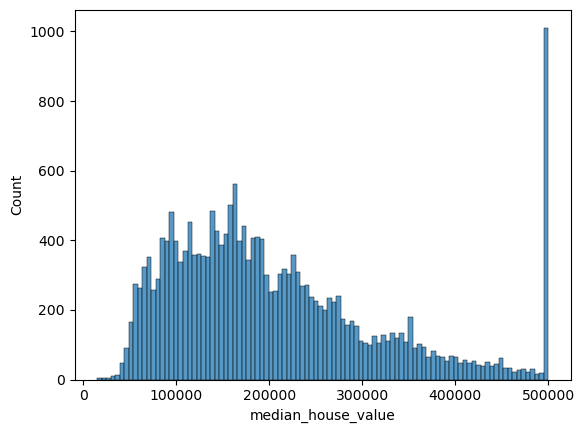

In [26]:
df = pd.read_csv('housing.csv')

print('Distribution of median_house_value')
sns.histplot(df.median_house_value)

-------------

# Preparing the dataset
For this homework, we only want to use a subset of data.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Next, use only the following columns:

- 'latitude',
- 'longitude',
- 'housing_median_age',
- 'total_rooms',
- 'total_bedrooms',
- 'population',
- 'households',
- 'median_income',
- 'median_house_value'

In [40]:
# Filter records to meet criteria: ocean_proximity is either '<1H OCEAN' or 'INLAND'
df2 = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Choose only specified columns
cols = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

df3 = df2[cols]

----------

# Question 1
There's one feature with missing values. What is it?

- total_rooms
- total_bedrooms
- population
- households

In [58]:
# Find which columns have missing values.
df3.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

---------

# Question 2
What's the median (50% percentile) for variable 'population'?

- 995
- 1095
- 1195
- 1295

In [45]:
df3['population'].median()

1195.0

-------------

# Prepare and split the dataset
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [66]:
n = len(df3)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

print(f'Total no. of records: {n}')
print(f'Validation Set size: {n_val}')
print(f'Test set size: {n_test}')
print(f'Training set size: {n_train}')

np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df3.iloc[idx]

df_train_orig = df_shuffled.iloc[:n_train].copy()
df_val_orig = df_shuffled.iloc[n_train: (n_train + n_val)].copy()
df_test_orig = df_shuffled.iloc[(n_train + n_val):].copy()

y_train = np.log1p(df_train_orig.median_house_value.values)
y_val = np.log1p(df_val_orig.median_house_value.values)
y_test = np.log1p(df_test_orig.median_house_value.values)

Total no. of records: 15687
Validation Set size: 3137
Test set size: 3137
Training set size: 9413


-----------

# Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

### Options:

- With 0
- With mean
- Both are equally good

In [67]:
# Option 1 : Fill missing column - total_bedrooms with 0

df_train = df_train_orig.copy()
df_val = df_val_orig.copy()
df_test = df_test_orig.copy()

df_train['total_bedrooms'] = df_train['total_bedrooms'].fillna(0)
df_val['total_bedrooms'] = df_val['total_bedrooms'].fillna(0)
df_test['total_bedrooms'] = df_test['total_bedrooms'].fillna(0)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [68]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [74]:
X_train = df_train.values
w_0, w = train_linear_regression(X_train, y_train)

In [75]:
y_pred = w_0 + X_train.dot(w)

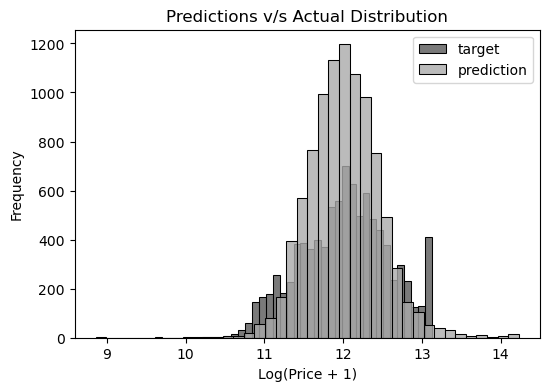

In [77]:
plt.figure(figsize=(6,4))

sns.histplot(y_train, label = 'target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions v/s Actual Distribution')

plt.show()

In [78]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [79]:
rmse(y_train, y_pred)

0.3402719715829534

In [80]:
X_val = df_val.values
y_pred = w_0 + X_val.dot(w)

In [82]:
rmse(y_val, y_pred)

0.3408479034201643

-----------

In [90]:
# Option 2 : Fill missing column - total_bedrooms with mean of total_bedrooms

df_train = df_train_orig.copy()
df_val = df_val_orig.copy()
df_test = df_test_orig.copy()

df_train.isnull().sum()
avg = df_train['total_bedrooms'].mean()
avg

df_train['total_bedrooms'] = df_train['total_bedrooms'].fillna(avg)
df_val['total_bedrooms'] = df_val['total_bedrooms'].fillna(avg)
df_test['total_bedrooms'] = df_test['total_bedrooms'].fillna(avg)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [92]:
X_train = df_train.values
w_0, w = train_linear_regression(X_train, y_train)

In [93]:
y_pred = w_0 + X_train.dot(w)

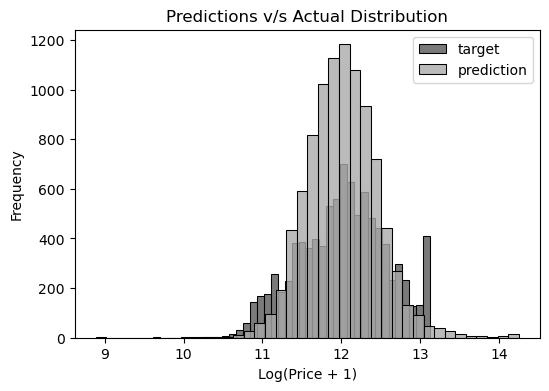

In [94]:
plt.figure(figsize=(6,4))

sns.histplot(y_train, label = 'target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions v/s Actual Distribution')

plt.show()

In [95]:
rmse(y_train, y_pred)

0.340030082226426

In [96]:
X_val = df_val.values
y_pred = w_0 + X_val.dot(w)

In [97]:
rmse(y_val, y_pred)

0.3405699801479319

# Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If there are multiple options, select the smallest r.

### Options:

- 0
- 0.000001
- 0.001
- 0.0001

In [98]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [99]:
# Option 1 : Fill missing column - total_bedrooms with 0

df_train = df_train_orig.copy()
df_val = df_val_orig.copy()
df_test = df_test_orig.copy()

df_train['total_bedrooms'] = df_train['total_bedrooms'].fillna(0)
df_val['total_bedrooms'] = df_val['total_bedrooms'].fillna(0)
df_test['total_bedrooms'] = df_test['total_bedrooms'].fillna(0)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [100]:
X_train = df_train.values
X_val = df_val.values

In [107]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    err = rmse(y_val, y_pred)
    print('%5s, %.2f, %6s, %6s' % (r, w_0, err, round(err, 2)))

    0, -9.76, 0.3405399458294097,   0.34
1e-06, -9.76, 0.3405399489576252,   0.34
0.0001, -9.76, 0.3405402589978592,   0.34
0.001, -9.74, 0.3405430991904281,   0.34
 0.01, -9.56, 0.3405735433507777,   0.34
  0.1, -8.06, 0.3410078384888271,   0.34
    1, -3.13, 0.3446958314915331,   0.34
    5, -0.84, 0.34757242531958826,   0.35
   10, -0.44, 0.34815331590381965,   0.35


# Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [111]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmses_list = list()

for sd in seeds:
    np.random.seed(sd)
    
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df3.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train: (n_train + n_val)].copy()
    df_test = df_shuffled.iloc[(n_train + n_val):].copy()

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    df_train['total_bedrooms'] = df_train['total_bedrooms'].fillna(0)
    df_val['total_bedrooms'] = df_val['total_bedrooms'].fillna(0)
    df_test['total_bedrooms'] = df_test['total_bedrooms'].fillna(0)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']

    X_train = df_train.values
    w_0, w = train_linear_regression(X_train, y_train)

    # y_pred = w_0 + X_train.dot(w)
    # err = rmse(y_train, y_pred)

    X_val = df_val.values
    y_pred = w_0 + X_val.dot(w)
    err = rmse(y_val, y_pred)

    print('Seed : %5s, %6s' % (sd, err))
    rmses_list.append(err)

# print(f'RMSEs: {rmses_list}')
std = np.std(rmses_list)
print(f'Standard Deviation of RMSEs: {round(std, 3)}')


Seed :     0, 0.33773871601241534
Seed :     1, 0.33779993536620034
Seed :     2, 0.3384287006770243
Seed :     3, 0.3320049468307805
Seed :     4, 0.33944518625569475
Seed :     5, 0.3433819705265852
Seed :     6, 0.3385330211770784
Seed :     7, 0.34687476973049747
Seed :     8, 0.35127368659561153
Seed :     9, 0.3341558266517612
RMSEs: [0.33773871601241534, 0.33779993536620034, 0.3384287006770243, 0.3320049468307805, 0.33944518625569475, 0.3433819705265852, 0.3385330211770784, 0.34687476973049747, 0.35127368659561153, 0.3341558266517612]
Standard Deviation of RMSEs: 0.005


-----------

# Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43

In [113]:
np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df3.iloc[idx]

df_train = df_shuffled.iloc[:(n_train + n_val)].copy()
# df_val = df_shuffled.iloc[n_train: (n_train + n_val)].copy()
df_test = df_shuffled.iloc[(n_train + n_val):].copy()

y_train = np.log1p(df_train.median_house_value.values)
# y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

df_train['total_bedrooms'] = df_train['total_bedrooms'].fillna(0)
# df_val['total_bedrooms'] = df_val['total_bedrooms'].fillna(0)
df_test['total_bedrooms'] = df_test['total_bedrooms'].fillna(0)

del df_train['median_house_value']
# del df_val['median_house_value']
del df_test['median_house_value']

X_train = df_train.values
w_0, w = train_linear_regression_reg(X_train, y_train, 0.001)

X_test = df_test.values
y_pred = w_0 + X_test.dot(w)
err = rmse(y_test, y_pred)

print(f'RMSE on test dataset: {round(err, 2)}')

RMSE on test dataset: 0.33
